In [16]:
import pandas as pd
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, LSTM, BatchNormalization,Masking
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
from sklearn import preprocessing
from BinanceFuturesPy.futurespy import Client
from binance.client import Client as ClientReal
import talib
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime as Datetime
from datetime import timedelta
import os.path, datetime
import os
import platform
from sklearn.model_selection import train_test_split
from zigzag import *
import math

SEQ_LEN = 60000  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "BTCUSDT"
EPOCHS = 100  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

import warnings
warnings.filterwarnings("ignore", message="numpy.ndarray size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

api_key = ''
api_secret = ''

client = Client(api_key, api_secret)
clientreal = ClientReal(api_key, api_secret)

In [17]:
def preprocess_df(df,shafle=False,trainTest=False):
    
    if trainTest:
        df = df.drop(df[df.volume == 0].index)

    X_d = df['close'].dropna()
    pivots = peak_valley_pivots(X_d.values, 0.02, -0.02)
    pivots[0] = 0
    pivots[-1] = 0
    ts_pivots = pd.Series(X_d, index=X_d.index)
    pivot_low = ts_pivots[pivots == -1]
    pivot_high = ts_pivots[pivots == 1]
    
    df = df[['close','volume','rsi','ADX']]
    df['target'] = 0.
    df.loc[pivot_high.index,'target'] = 1.
    df.loc[pivot_low.index,'target'] = 2.
    
    for col in df.columns:  # go through all of the columns
        if col != "target":# normalize all ... except for the target itself!
            if col != "rsi":
                df[col] = df[col].pct_change()
            # pct change "normalizes" the different currencies (each crypto coin has vastly diff values, we're really more interested in the other coin's movements)
            df.dropna(inplace=True)
            # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.

    df.dropna(inplace=True)  # cleanup again... jic.
        
    df = scale(df)
    
    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
    for i in df.values:  # iterate over the values
        scale_liste_buy = [1,2,3,4,5,6,7,8,9,10,11]
        scale_liste_sell = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11]
        if df.values[0][-1] == -1:
            prev_days.append([n for n in i[:-1]])
            for j in scale_liste_sell[1:]:
                if j == i[-1]:
                    sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
                if i[-1] == 1:
                    prev_days = deque(maxlen=SEQ_LEN)
                    break
                    
            for j in scale_liste_buy[1:]:
                if j == i[-1]:
                    sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
                if i[-1] == -1:
                    prev_days = deque(maxlen=SEQ_LEN)
                    break
            
        elif df.values[0][-1] == 1:
            prev_days.append([n for n in i[:-1]])
            for j in scale_liste_buy[1:]:
                if j == i[-1]:
                    sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
                if i[-1]== -1:
                    prev_days = deque(maxlen=SEQ_LEN)
                    break
                    
            prev_days.append([n for n in i[:-1]])
            for j in scale_liste_sell[1:]:
                if j == i[-1]:
                    sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
                if i[-1] == 1:
                    prev_days = deque(maxlen=SEQ_LEN)
                    break
                    
    counter =0
        
    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets
    neutral = []
    
    if shafle:
        
        random.shuffle(sequential_data)
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 1:  # if it's a "not buy"
                sells.append([seq, target])  # append to sells list
            elif target == 2:  # otherwise if the target is a 1...
                buys.append([seq, target])  # it's a buy!
            elif target == 0:  # otherwise if the target is a 1...
                neutral.append([seq, target])  # it's a buy!
    
        random.shuffle(buys)  # shuffle the buys
        random.shuffle(sells)
        random.shuffle(neutral)# shuffle the sells!
    
        sequential_data = buys+sells+neutral # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
        
    else:
        for i in range(len(df.values)):
            if df.iloc[-i-1][-1] == 0 :
                counter +=1
            else:
                break
        sequential_data.append([df.tail(counter).values[:,:-1], 0])
    
    X = []
    y = []
 
    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        
    y = convert_negative_value(y)
    
    Max = 0
    
    for i in range(len(X)):
        PMax = len(X[i])
        if PMax > Max:
            Max = PMax
            
    for i in range(len(X)):
        if len(X[i]) < Max:
            Complimentary_array = np.zeros((Max-len(X[i]),4))
            Complimentary_array[[Complimentary_array==0]] = -10
            X[i] = np.concatenate((X[i], Complimentary_array), axis=0)
            
    if seqRight(np.array(X)) == len(df):
        print('Sequence lenght is Right')
    else:
        print('There is problem with sequence')
        print(seqRight(np.array(X)))
        print(len(df))
    
    if trainTest:
        train_x, val_x, train_y, val_y = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=50)
        return train_x, train_y, val_x, val_y
    else:
        return np.array(X), np.array(y) # return X and y...and make X a numpy array!

#Function---------------------------------------------------------------------------------------------------

def checkForSequenceError(df,seq_x,seq_y):
    
    new_data_plot = df.copy()
    new_data_plot['target'] = 0
    seq_counter = 0
    
    for i, j in enumerate(range(len(seq_x))):
        seq_counter += len(seq_x[j][seq_x[j] != -10].reshape(int(len(seq_x[j][seq_x[j] != -10])/3),3))
        new_data_plot['target'][seq_counter-1] = test_y[i]

    return new_data_plot

def scale(df):
    prev_days = deque(maxlen=SEQ_LEN)
    counter_list = []
    scale_liste_buy = [1,2,3,4,5,6,7,8,9,10,11]
    scale_liste_sell = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11]
    k=0
    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if i[-1] == 1:
            counter_list.append([len(prev_days)-1,1])
            prev_days = deque(maxlen=SEQ_LEN)
        if i[-1] == 2:
            counter_list.append([len(prev_days)-1,2])
            prev_days = deque(maxlen=SEQ_LEN)
            
    j = 0
    for i in counter_list:
        j += i[0]
        size = math.ceil((i[0])/10)
        if i[1] == 1:
            for it in scale_liste_buy:
                if k < j:
                    df['target'][k] = it
                    k += size

                else:
                    if k == j:
                        df['target'][k] = scale_liste_buy[-1]
                        break
                    else:
                        k += i[0]-math.ceil(i[0]/size)*size
                        df['target'][k] = scale_liste_buy[-1]

                        break
        
        elif i[1] == 2:
            for it in scale_liste_sell:
                if k < j:
                    
                    df['target'][k] = it
                    k += size

                else:
                    if k == j:
                        df['target'][k] = scale_liste_sell[-1]
                        break
                    else:
                        k += i[0]-math.ceil(i[0]/size)*size
                        df['target'][k] = scale_liste_sell[-1]
                        break
    df.to_csv('test.csv')
    return df

def convert_negative_value(seq):
    for i in range(len(seq)):
        if seq[i] < 0 :
            seq[i] = np.abs(seq[i])+11
    return seq

def seqRight(seq_x):
    cc = 0
    for i in range(len(seq_x)):
        cc += len(seq_x[i][seq_x[i] != -10].reshape(int(len(seq_x[i][seq_x[i] != -10])/4),4))
    return cc

def creation_date(path_to_file):
    
    if platform.system() == 'Windows':
        return os.path.getctime(path_to_file)
    else:
        stat = os.stat(path_to_file)
        try:
            return stat.st_birthtime
        except AttributeError:
            # We're probably on Linux. No easy way to get creation dates here,
            # so we'll settle for when its content was last modified.
            return stat.st_mtime
def predictTheMove(x):
    predec= model.predict(x)
    lastSequence = predec[-1]
    buyRatio = 0 
    sellRatio = 0 

    where = np.where(lastSequence == np.amax(lastSequence))
    print('The indicator is = {} '.format(where[0][0]))
    for i in range(lastSequence.shape[0]):
        if i > 0:
            if i < 12:
                buyRatio += lastSequence[i]
                buyRatiof = buyRatio
            if i > 12:
                sellRatio += lastSequence[i]
                sellRatiof = sellRatio
    print('point 2 buy = {0:.0%} '.format(lastSequence[2]))
    print('point 5 buy = {0:.0%} '.format(lastSequence[5]))
    print('point 10 sell-pivot = {0:.0%} '.format(lastSequence[10]))
    print('point 12 sell-pivot = {0:.0%} '.format(lastSequence[12]))
    print('point 15 sell = {0:.0%} '.format(lastSequence[15]))
    print('point 21 buy-pivot = {0:.0%} '.format(lastSequence[21]))
    print('Sell Ratio = {0:.0%} '.format(sellRatiof))
    print('Buy Ratio = {0:.0%}'.format(buyRatiof))

    if buyRatiof > sellRatiof:
        print('Buy')
    else:
        print('Sell')

**Training and validation data**:

In [18]:
FileNew = Datetime.now()<datetime.datetime.fromtimestamp(creation_date('traininTestDataBTC.csv'))+timedelta(days= 1)

if FileNew:
    trainTestData = pd.read_csv('traininTestDataBTC.csv')
    trainTestData.set_index('date', inplace=True)
    trainTestData['rsi'] = talib.RSI(trainTestData.close, timeperiod=14)
    trainTestData['ADX'] = talib.ADX(trainTestData['close'], trainTestData['low'],trainTestData['close'], timeperiod=14)
else:
    candles_new = clientreal.get_historical_klines(symbol='BTCUSDT',interval=clientreal.KLINE_INTERVAL_1DAY,start_str= "01-01-2010",end_str="20-07-2021")
    trainTestData = pd.DataFrame({'close': np.asarray(candles_new)[:, 4]})
    trainTestData['close'] = trainTestData['close'].astype(float)
    trainTestData['close'] = talib.EMA(trainTestData['close'],5)
    trainTestData['date'] = np.asarray(candles_new)[:, 0]
    trainTestData['date'] = pd.to_datetime(trainTestData['date'], unit='ms')
    trainTestData['volume'] = np.asarray(candles_new)[:, 5].astype(float)
    trainTestData['high'] = np.asarray(candles_new)[:, 2].astype(float)
    trainTestData['low'] = np.asarray(candles_new)[:, 3].astype(float)
    trainTestData.to_csv('traininTestDataBTC.csv',index = False)
    
    trainTestData.set_index('date', inplace=True)
    trainTestData['rsi'] = talib.RSI(trainTestData.close, timeperiod=14)
    trainTestData['ADX'] = talib.ADX(trainTestData['close'], trainTestData['low'],trainTestData['close'], timeperiod=14)

In [19]:
train_x, train_y, val_x, val_y = preprocess_df(trainTestData,shafle=False,trainTest=True)

There is problem with sequence
8472
1401


**RNN_Model**

In [21]:
model = Sequential()

model.add(Masking(mask_value=-10, input_shape=(None, 4)))
model.add(LSTM(32,input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(23, activation='softmax'))

opt = tf.keras.optimizers.Adam(0.0001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=10,
    epochs=100,
    validation_data=(val_x,val_y)
)
# Score model
score = model.evaluate(val_x, val_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model

model.save('ld')

Epoch 1/100
49/49 [==============================] - 9s 60ms/step - loss: 3.4373 - accuracy: 0.0535 - val_loss: 3.1267 - val_accuracy: 0.0492
Epoch 2/100
49/49 [==============================] - 1s 17ms/step - loss: 3.3990 - accuracy: 0.0658 - val_loss: 3.1227 - val_accuracy: 0.0574
Epoch 3/100
49/49 [==============================] - 1s 14ms/step - loss: 3.3343 - accuracy: 0.0494 - val_loss: 3.1183 - val_accuracy: 0.0574
Epoch 4/100
49/49 [==============================] - 1s 15ms/step - loss: 3.3196 - accuracy: 0.0412 - val_loss: 3.1130 - val_accuracy: 0.0574
Epoch 5/100
49/49 [==============================] - 1s 15ms/step - loss: 3.2571 - accuracy: 0.0535 - val_loss: 3.1087 - val_accuracy: 0.0574
Epoch 6/100
49/49 [==============================] - 1s 14ms/step - loss: 3.1822 - accuracy: 0.0844 - val_loss: 3.1044 - val_accuracy: 0.0656
Epoch 7/100
49/49 [==============================] - 1s 15ms/step - loss: 3.1767 - accuracy: 0.0967 - val_loss: 3.0977 - val_accuracy: 0.0738
Epoch 

INFO:tensorflow:Assets written to: ld\assets


INFO:tensorflow:Assets written to: ld\assets


In [22]:
model = tf.keras.models.load_model('ld')

**Test data**:

In [32]:
candles_new = clientreal.get_historical_klines(symbol='BTCUSDT',interval=clientreal.KLINE_INTERVAL_1DAY,start_str= "28-07-2021")

test_data = pd.DataFrame({'close': np.asarray(candles_new)[:, 4]})
test_data['close'] = test_data['close'].astype(float)
test_data['close'] = talib.EMA(test_data['close'],5)
test_data['rsi'] = talib.RSI(test_data.close, timeperiod=14)
test_data['date'] = np.asarray(candles_new)[:, 0]
test_data['date'] = pd.to_datetime(test_data['date'], unit='ms')
test_data['volume'] = np.asarray(candles_new)[:, 5].astype(float)
test_data.set_index('date', inplace=True)
test_data['high'] = np.asarray(candles_new)[:, 2].astype(float)
test_data['low'] = np.asarray(candles_new)[:, 3].astype(float)
test_data['ADX'] = talib.ADX(test_data['close'], test_data['low'], test_data['close'], timeperiod=14)

test_x, dummy = preprocess_df(test_data,shafle=False,trainTest=False)

There is problem with sequence
1290
268


In [33]:
predictTheMove(test_x)

4/4 [==============================] - 0s 16ms/step
The indicator is = 2 
point 2 buy = 15% 
point 5 buy = 4% 
point 10 sell-pivot = 3% 
point 12 sell-pivot = 1% 
point 15 sell = 1% 
point 21 buy-pivot = 3% 
Sell Ratio = 40% 
Buy Ratio = 58%
Buy


In [34]:
model.predict(test_x)[-1]

4/4 [==============================] - 0s 11ms/step


array([0.01263855, 0.01272887, 0.15054281, 0.01279414, 0.03580145,
       0.0352688 , 0.10078818, 0.04642135, 0.06923123, 0.07155325,
       0.02694765, 0.01424451, 0.014936  , 0.00993838, 0.00344308,
       0.01229293, 0.01071677, 0.07433199, 0.07030078, 0.1385341 ,
       0.03455858, 0.03291039, 0.00907621], dtype=float32)

In [35]:
print('point 2 buy = {0:.0%} '.format(0.1))

point 2 buy = 10% 


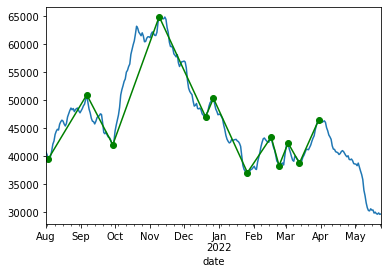

In [37]:
X =test_data['close'][-10000:].dropna()
pivots = peak_valley_pivots(X.values, 0.05, -0.05)
ts_pivots = pd.Series(X, index=X.index)
pivots[0] = 0
pivots[-1] = 0
ts_pivots = ts_pivots[pivots != 0]
X.plot()
ts_pivots.plot(style='g-o');